In [81]:
import numpy as np
import pickle

In [82]:
def evaluate_predictive_power(output_prediction):
    '''input: [] a list of true false classification of within-chunk reaction times '''
    '''output: chunk length as a function of sequence length '''
    chunk_classification = chunk_classification_model(output_prediction)     
    chunk_collect = get_model_chunk_collect(model_prediction, chunk_classification)
    
    return 
    
# at any point, guess the subject's chunk
def get_model_chunk_collect(model_prediction, withinchunk_classification):
    '''returns the chunks'''
    chunk_collect = []
    for i in range(0,len(withinchunk_classification)):
        chunk = []# initiate with an empty chunk 
        if withinchunk_classification[i] == False: # between chunk element
            chunk.append(model_prediction[i])
            nextidx  = i+1
            if nextidx<len(withinchunk_classification):
                while withinchunk_classification[nextidx] == True :
                    nextinst = model_prediction[nextidx]
                    chunk.append(nextinst)
                    nextidx = nextidx+1
                    if nextidx >=len(withinchunk_classification):
                        break;
            chunk_collect.append(chunk)
    
    return chunk_collect

# Comparing Human, HCM, and RNN

In [83]:
from sklearn.mixture import GaussianMixture
import random 

def chunk_classification_model(X):
    '''X: prediction sequence, a sequence of array with their prediction confidence translated into log likelihood
        output: classified chunks'''
    AIC, BIC, model = learn_gaussian_mixture(X.reshape(-1,1), n_mixture = 3)
    model = model[0]

    reaction_time = np.array(X)
    responsibilities = model.predict_proba(reaction_time.reshape(-1, 1))# likelihood of belonging to which gaussian mixture
    prediction = model.predict(reaction_time.reshape(-1, 1))# likelihood of belonging to which gaussian mixture

    within_chunk_model_index = np.argmin(model.means_)
    within_chunk = (prediction == within_chunk_model_index)
    p_within_chunk = responsibilities[:,within_chunk_model_index]

    return within_chunk # true for within-chunk

def learn_gaussian_mixture(X, n_mixture = 3):
    N = [n_mixture] #np.arange(1, 11)
    models = [None for i in range(len(N))]

    for i in range(len(N)):
        models[i] = GaussianMixture(N[i]).fit(X)

    # compute the AIC and the BIC
    AIC = [m.aic(X) for m in models]
    BIC = [m.bic(X) for m in models]
    
    return AIC, BIC, models


def generateseq(groupcond,seql = 600):
    seq = []
    if groupcond == 'c2':
        while len(seq) < seql:
            seq = seq + np.random.choice([[1,2],[3],[4]])
        return seq[0:seql]
    if groupcond == 'c3':
        while len(seq) < seql:
            seq = seq + np.random.choice([[1,2,3],[4]])
        return seq[0:seql]
    if groupcond == 'ind':
        while len(seq) < seql:
            seq = seq + [np.random.choice([1,2,3,4])]
        return seq[0:seql]

Evaluate chunk size on participants. 

In [84]:
file = open('../InputData/human_data/c3_chunks.pkl','rb')
c3subject = pickle.load(file)
file.close()

To output such a chunked sequence, as HCM already parses the sequence with the biggest explanatory unit that is consistent with the sequence instruction, this parsed sequence can also be used to evaluate the predictive power. 

Measure of predictive power: the size of learned representation in parsing a sequence. 



# Plot predictive power and chunk reuse curve on participants

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dfc3 = {}
dfc3['ID'] = []
dfc3['time'] = []
dfc3['chunksize'] = []
for ID in list(c3subject.keys()):
    L_ID = []
#     training_length = []
    tl = 0
    for i in range(0, len(c3subject[ID])):
        L = len(c3subject[ID][i])
        tl = tl + L
        if tl>200 and tl < 800: 
            dfc3['ID'].append(ID)
            dfc3['time'].append(tl-200)
            L_ID.append(L)
            dfc3['chunksize'].append(np.mean(L_ID[len(L_ID)-30:len(L_ID)]))
#             training_length.append(tl)
dfc3 = pd.DataFrame.from_dict(dfc3)

predictive power increase is very rusted. There is a variability of chunk length as a function of training sequence. 

this is plotting the moving average

meanwhile, evaluate the parsing probability of chunks, as HCM learns through the sequence,

## RNN

In [86]:
# rnnchunk_classification
# rnnchunk_collect
import pandas as pd
import pickle
rnn_path = '../OutputData/c3_RNN.pkl'
with open(rnn_path, 'rb') as f:
    rnn = pickle.load(f)



In [87]:
# rnn['seq'] = list(rnn['seq'][0].flatten())
# rnn['prob'] = list(rnn['prob'][0].flatten())

lseq = []
pseq = []
for s in range(0, len(rnn['seq'])):
    lseq.append(rnn['seq'][s][0][0])
    pseq.append(rnn['prob'][s][0][0])

rnn['seq'] = lseq
rnn['prob'] = pseq
rnn = pd.DataFrame.from_dict(rnn)


In [97]:
dfrnn

,time,chunksize,ID,lr
0,1,1.000000,0,0.001
1,2,1.000000,0,0.001
2,3,1.000000,0,0.001
3,4,1.000000,0,0.001
4,5,1.000000,0,0.001
...,...,...,...,...
53086,1795,1.566667,34,0.001
53087,1796,1.533333,34,0.001
53088,1798,1.566667,34,0.001
53089,1799,1.533333,34,0.001


In [98]:
rnn

,seq,prob,id,learning_rate,model_type
0,4,0.204204,0,0.001,model0
1,4,0.205711,0,0.001,model1
2,4,0.225858,0,0.001,model2
3,4,0.185939,0,0.001,model0
4,4,0.179243,0,0.001,model1
...,...,...,...,...,...
62995,3,0.240088,34,0.001,model1
62996,3,0.227047,34,0.001,model2
62997,1,0.311355,34,0.001,model0
62998,1,0.199910,34,0.001,model1


In [100]:
dfrnn = {}
dfrnn['time'] = []
dfrnn['chunksize'] = []
dfrnn['ID'] = []
dfrnn['lr'] = []
dfrnn['model'] = []

rnn_chunk_record = {}

n_sample = 35

for lr in [0.001]:
    for i in range(0,n_sample):
        for model in ['model0','model1','model2']:
            # get one sample here: 
            rt_rnn = -np.log(rnn[(rnn['id'] == i) & (rnn['learning_rate'] == lr) & (rnn['model_type'] == model)]['prob']) # how many consecutive predictions about the upcoming chunks can you make consecutively
            rnnchunk_classification = chunk_classification_model(np.array(rt_rnn))

            rnnmodel_prediction = list(rnn[(rnn['id'] == i) & (rnn['learning_rate'] == lr) & (rnn['model_type'] == model)]['seq'].astype('int'))
            rnnchunk_collect = get_model_chunk_collect(rnnmodel_prediction, rnnchunk_classification)
            rnn_chunk_record[i] = rnnchunk_collect

            L_ID = []
            tl = 0
            for j in range(0, len(rnnchunk_collect)):
                L = len(rnnchunk_collect[j])
                tl = tl + L
                dfrnn['time'].append(tl)
                L_ID.append(L)
                dfrnn['chunksize'].append(np.mean(L_ID[max(0,len(L_ID)-30):len(L_ID)]))
                dfrnn['ID'].append(i)
                dfrnn['lr'].append(lr)
                dfrnn['model'].append(model)

dfrnn = pd.DataFrame.from_dict(dfrnn)

In [109]:
HCM_path = '../OutputData/HCM_time_chunksize.pkl'
import pickle
with open(HCM_path, 'rb') as f:
    HCM_learn = pickle.load(f)
    
HCM_learn['smoothed']= []
for i in range(0,len(HCM_learn['chunksize'])):
    if HCM_learn['time'][i]%600 < 31 or i<31: 
        HCM_learn['smoothed'].append(np.mean(HCM_learn['chunksize'][i]))
    else:
        HCM_learn['smoothed'].append(np.mean(HCM_learn['chunksize'][i-30:i]))

# dfhcm = {}
# dfhcm['ID'] = []
# dfhcm['time'] = []
# dfhcm['chunksize'] = []

HCM_learn = pd.DataFrame.from_dict(HCM_learn)

In [105]:
PARSER_path = '../OutputData/PARSER_time_chunksize.pkl'
with open(PARSER_path, 'rb') as f:
    PARSER_learn = pickle.load(f)
    
PARSER_learn['smoothed']= []
for i in range(0,len(PARSER_learn['chunksize'])):
    if PARSER_learn['time'][i]%600 < 31 or i<31: 
        PARSER_learn['smoothed'].append(np.mean(PARSER_learn['chunksize'][i]))
    else:
        PARSER_learn['smoothed'].append(np.mean(PARSER_learn['chunksize'][i-30:i]))

# dfhcm = {}
# dfhcm['ID'] = []
# dfhcm['time'] = []
# dfhcm['chunksize'] = []

PARSER_learn = pd.DataFrame.from_dict(PARSER_learn)

Text(0.5, 0, 'Time')

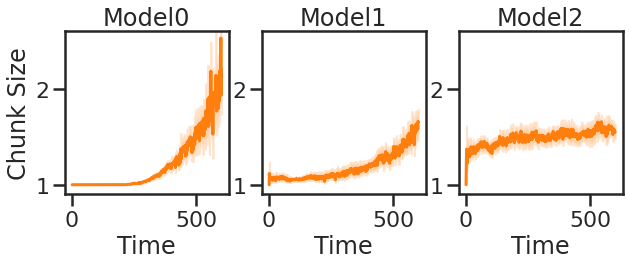

In [102]:
plt.figure(figsize = (10,3))

plt.subplot(1,3,1)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[dfrnn['model'] == 'model0'])
plt.title('Model0')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')


plt.subplot(1,3,2)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[dfrnn['model'] == 'model1'])
plt.ylim([0.9,2.6])
plt.title('Model1')
plt.ylabel('')
plt.xlabel('Time')

plt.subplot(1,3,3)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[dfrnn['model'] == 'model2'])
plt.title('Model2')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')


Text(0.5, 0, 'Time')

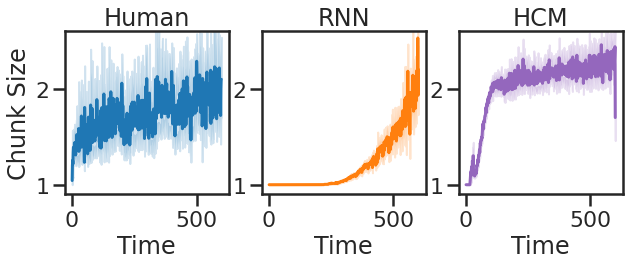

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (10,3))

plt.subplot(1,3,1)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfc3)
plt.title('Human')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')


plt.subplot(1,3,2)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[(dfrnn['lr'] == 0.001)& (dfrnn['model'] == 'model0')])
plt.ylim([0.9,2.6])
plt.title('RNN')
plt.ylabel('')
plt.xlabel('Time')

plt.subplot(1,3,3)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=HCM_learn)
plt.title('HCM')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')


Text(0.5, 0, 'Time')

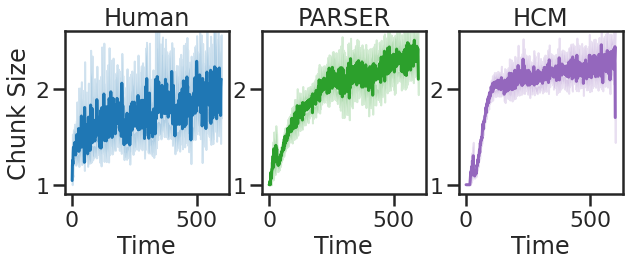

In [124]:
plt.figure(figsize = (10,3))

plt.subplot(1,3,1)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfc3)
plt.title('Human')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')

plt.subplot(1,3,2)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[2], data=PARSER_learn)
plt.title('PARSER')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')


plt.subplot(1,3,3)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=HCM_learn)
plt.title('HCM')
plt.ylim([0.9,2.6])
plt.ylabel('')
plt.xlabel('Time')



Text(0.5, 0, 'Time')

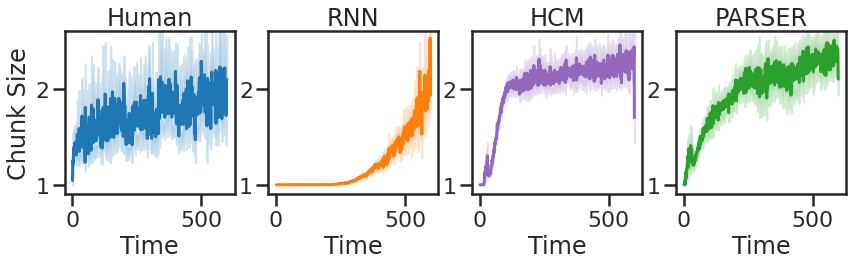

In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (14,3))

plt.subplot(1,4,1)
sns.set_style("ticks")
sns.set_context("poster")
tips = sns.load_dataset("tips")
g = sns.lineplot(x="time", y="chunksize",color = palette[0], data=dfc3)
plt.title('Human')
plt.ylim([0.9,2.6])
plt.ylabel('Chunk Size')
plt.xlabel('Time')


plt.subplot(1,4,2)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="chunksize", color = palette[1], data=dfrnn[(dfrnn['lr'] == 0.001)& (dfrnn['model'] == 'model0')])
plt.ylim([0.9,2.6])
plt.title('RNN')
plt.ylabel('')
plt.xlabel('Time')

plt.subplot(1,4,3)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=HCM_learn)
plt.title('HCM')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')


plt.subplot(1,4,4)
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[2], data=PARSER_learn)
plt.title('PARSER')
plt.ylabel('')
plt.ylim([0.9,2.6])
plt.xlabel('Time')

Text(0.5, 0, 'Time')

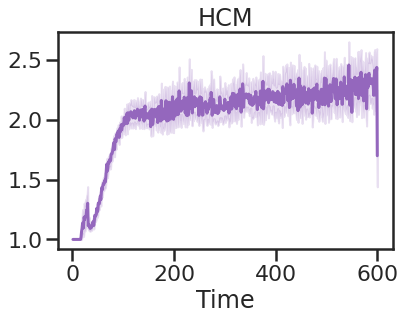

In [118]:
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=HCM_learn)
plt.title('HCM')
plt.ylabel('')
#plt.ylim([0.9,2.6])
plt.xlabel('Time')

Text(0.5, 0, 'Time')

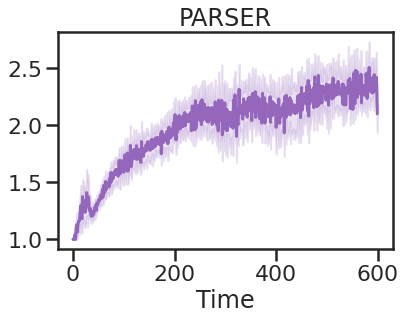

In [127]:
sns.set_style("ticks")
sns.set_context("poster")
palette = sns.color_palette("tab10")
g = sns.lineplot(x="time", y="smoothed",color = palette[4], data=PARSER_learn)
plt.title('PARSER')
plt.ylabel('')
#plt.ylim([0.9,2.6])
plt.xlabel('Time')

[Text(0, 0, 'Human'), Text(1, 0, 'RNN'), Text(2, 0, 'HCM')]

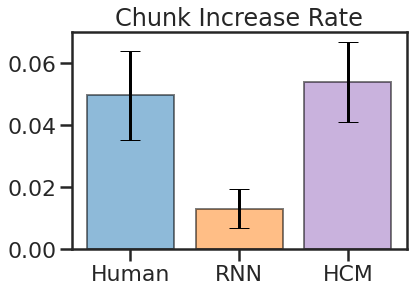

In [128]:
# Can evaluate the average growth rate in the first 300 time step. 
pl = 30
mean_human_chunk_increase = np.mean(dfc3['chunksize'].pct_change(periods=pl))
std_human_chunk_increase = np.std(dfc3['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_rnn_chunk_increase = np.mean(dfrnn['chunksize'].pct_change(periods=pl))
std_rnn_chunk_increase = np.std(dfrnn['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_hcm_chunk_increase = np.mean(HCM_learn['smoothed'].pct_change(periods=pl))
std_hcm_chunk_increase = np.std(HCM_learn['smoothed'].pct_change(periods=pl))/np.sqrt(600)

# sns.set_style("ticks")
# sns.set_context("poster")

palette = sns.color_palette("tab10")


# Create lists for the plot
Type = ['Human', 'RNN','HCM']
x_pos = np.arange(len(Type))
CTEs = [mean_human_chunk_increase, mean_rnn_chunk_increase, mean_hcm_chunk_increase]
error = [std_human_chunk_increase, std_rnn_chunk_increase, std_hcm_chunk_increase]


# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[0],palette[1], palette[4]],capsize=10)
ax.set_title('Chunk Increase Rate')
#ax.set_ylabel('Chunk Increase Rate')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)
# ax.set_title('Chunk Increase Rate')

# # Save the figure and show
# plt.tight_layout()
# plt.savefig('Chunkincreaserate.png')
# plt.show()




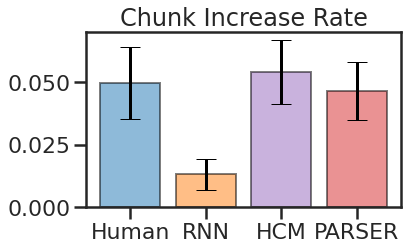

In [129]:
# Can evaluate the average growth rate in the first 300 time step. 
pl = 30
mean_human_chunk_increase = np.mean(dfc3['chunksize'].pct_change(periods=pl))
std_human_chunk_increase = np.std(dfc3['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_rnn_chunk_increase = np.mean(dfrnn['chunksize'].pct_change(periods=pl))
std_rnn_chunk_increase = np.std(dfrnn['chunksize'].pct_change(periods=pl))/np.sqrt(600)

mean_hcm_chunk_increase = np.mean(HCM_learn['smoothed'].pct_change(periods=pl))
std_hcm_chunk_increase = np.std(HCM_learn['smoothed'].pct_change(periods=pl))/np.sqrt(600)

mean_parser_chunk_increase = np.mean(PARSER_learn['smoothed'].pct_change(periods=pl))
std_parser_chunk_increase = np.std(PARSER_learn['smoothed'].pct_change(periods=pl))/np.sqrt(600)

# sns.set_style("ticks")
# sns.set_context("poster")

palette = sns.color_palette("tab10")


# Create lists for the plot
Type = ['Human', 'RNN','HCM','PARSER']
x_pos = np.arange(len(Type))
CTEs = [mean_human_chunk_increase, mean_rnn_chunk_increase, mean_hcm_chunk_increase,mean_parser_chunk_increase]
error = [std_human_chunk_increase, std_rnn_chunk_increase, std_hcm_chunk_increase,std_parser_chunk_increase]


# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[0],palette[1], palette[4], palette[3]],capsize=10)
ax.set_title('Chunk Increase Rate')
#ax.set_ylabel('Chunk Increase Rate')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)
# ax.set_title('Chunk Increase Rate')

# Save the figure and show
plt.tight_layout()
plt.savefig('Chunkincreaserate.png')
plt.show()




In [59]:
HCM_path = '../OutputData/HCM_chunk.pkl'
import pickle
with open(HCM_path, 'rb') as f:
    hcm_chunk_record = pickle.load(f)

# Correlating reaction time data with prediction probability:

In [130]:
import pickle
import pandas as pd
with open('../OutputData/hcm_rnn_rt_p.pkl', 'rb') as f:
    data = pickle.load(f)
    
import numpy as np
    
dfsubject = pd.read_csv('../InputData/human_data/filtered_exp1.csv')
df = pd.DataFrame.from_dict(data)

In [131]:
data

{'id': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,

In [78]:
import matplotlib.pyplot as plt
from numpy.random import randn
from numpy.random import seed
from scipy.stats import spearmanr
import math 
# seed random number generator
seed(1)

c_hcm = []
c_rnn = []
c_parser = []

dfrt = {}
dfrt['ID'] = []
dfrt['rt'] = []
dfrt['lgphcm'] = []
dfrt['lgprnn'] = []
dfrt['lgpparser'] = []


for ID in np.unique(dfsubject[dfsubject['condition'] == 2]['id']):
    rt_hcm = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_hcm'])))
    rt_subj = list(df[(df['id'] == ID) & (df['rt'] <=1000)]['rt'])
    rt_rnn = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_rnn'])))
    rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
    # calculate spearman's correlation
    corr_hcm, p_hcm = spearmanr(rt_subj, rt_hcm)
    corr_rnn, p_rnn = spearmanr(rt_subj, rt_rnn)
    corr_parser, p_parser = spearmanr(rt_subj, rt_parser)

#     plt.plot(rt_subj,rt_hcm,'bo')
#     plt.plot(rt_subj,rt_rnn,'ro')
#     plt.show()
    dfrt['rt']+=rt_subj
    dfrt['ID']+= [ID]*len(rt_subj)
    dfrt['lgphcm'] += rt_hcm
    dfrt['lgprnn'] += rt_rnn
    dfrt['lgpparser'] += rt_parser
    if not math.isnan(p_value):
        c_hcm.append(corr_hcm)
        c_rnn.append(corr_rnn)
        c_parser.append(corr_parser)

        
        
dfrt = pd.DataFrame.from_dict(dfrt)


<ipython-input-78-c55dac952243>:25: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-78-c55dac952243>:25: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-78-c55dac952243>:25: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-78-c55dac952243>:25: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-78-c55dac952243>:25: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.log(np.array(df[(df['id'] == ID) & (df['rt'] <=1000)]['p_parser'])))
<ipython-input-78-c55dac952243>:25: RuntimeWarning: divide by zero encountered in log
  rt_parser = list(-np.l

In [80]:
print('RNN correlation: %.3f' % (np.mean(c_rnn)))
print('HCM correlation: %.3f' % (np.mean(c_hcm)))
print('PARSER correlation: %.3f' % (np.mean(c_parser)))


RNN correlation: 0.238
HCM correlation: 0.139
PARSER correlation: 0.157


In [65]:
import rpy2
%load_ext rpy2.ipython

In [72]:
%%R -i dfrt -o betashcm
library(lme4)
library(lmerTest)
m1<-lmer('rt ~ scale(lgphcm) + (scale(lgphcm) |ID)', data=dfrt)
betashcm<-summary(m1)
print(summary(m1))

UsageError: Line magic function `%%R` not found.


In [67]:
%%R -i dfrt -o betasrnn
library(lme4)
library(lmerTest)
m1<-lmer('rt ~ scale(lgprnn) + (scale(lgprnn) |ID)', data=dfrt)
betasrnn<-summary(m1)
print(summary(m1))


NotImplementedError: Conversion 'py2rpy' not defined for objects of type '<class 'str'>'

<Figure size 216x144 with 0 Axes>

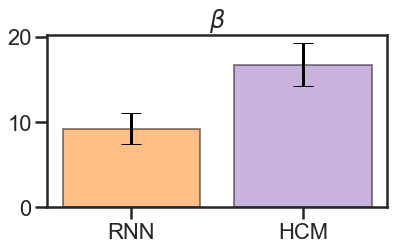

In [153]:
chcm_mean = 16.742
crnn_mean = 9.244

# Calculate the standard deviation
chcm_std = 2.552
crnn_std = 1.825


# Create lists for the plot
Type = ['RNN','HCM']
x_pos = np.arange(len(Type))
CTEs = [crnn_mean, chcm_mean]
error = [crnn_std,chcm_std]
plt.figure(figsize = (3,2))
# Build the plot
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black',edgecolor = 'k', color = [palette[1], palette[4]], capsize=10)
ax.set_title(r'$\beta$')
ax.set_xticks(x_pos)
ax.set_xticklabels(Type)
#ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('Regression_Coefficient.png')
plt.show()